In [4]:
!pip install scanpy
!pip install leidenalg

In [5]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

To do:
- import data
- subset features
- calculate neighbors
- UMAP
- pseudotime

In [6]:
# Load data
data = pd.read_csv('../data/mitocells.csv', index_col=0)

print('Data loaded.')

Data loaded.


In [7]:
data.columns
len(data)

8179

In [8]:
# Subset to relevant features
data_sub = data.filter(items=['cell_height',
                            'cell_volume',
                            'cell_surface_area',
                            'nuclear_volume',
                            'nuclear_height',
                            'nuclear_surface_area'], axis=1)

In [9]:
data_sub

,cell_height,cell_volume,cell_surface_area,nuclear_volume,nuclear_height,nuclear_surface_area
0,7.258311,1041.073422,1020.683302,383.806509,5.524983,468.150591
1,9.641637,1755.358826,1389.687837,568.221851,7.691643,527.159395
2,5.849982,2110.221906,1809.392060,595.790895,4.441653,655.575132
3,6.824979,1439.708273,1432.407018,452.941443,4.983318,528.121750
4,7.583310,1917.270382,1597.932111,485.102785,4.766652,581.286006
...,...,...,...,...,...,...
8174,11.374965,3327.605494,1910.861852,159.743819,9.099972,677.052084
8175,10.074969,2617.028766,1768.973142,269.798772,7.908309,481.201067
8176,10.291635,3029.075618,2332.913282,349.993618,8.233308,638.158851
8177,10.291635,3498.659691,2550.147362,268.471430,8.558307,620.460904


In [10]:
# Convert data to AnnData
obj = sc.AnnData(data_sub)

obj.obs['cell_stage'] = data['cell_stage'].values
obj.obs['CellId'] = data['CellId'].values

# Scale
sc.pp.scale(obj)

/tmp/ipykernel_22383/1985355170.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  obj = sc.AnnData(data_sub)
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
# Calculate neighborhood graph
sc.pp.neighbors(obj, n_pcs=0)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


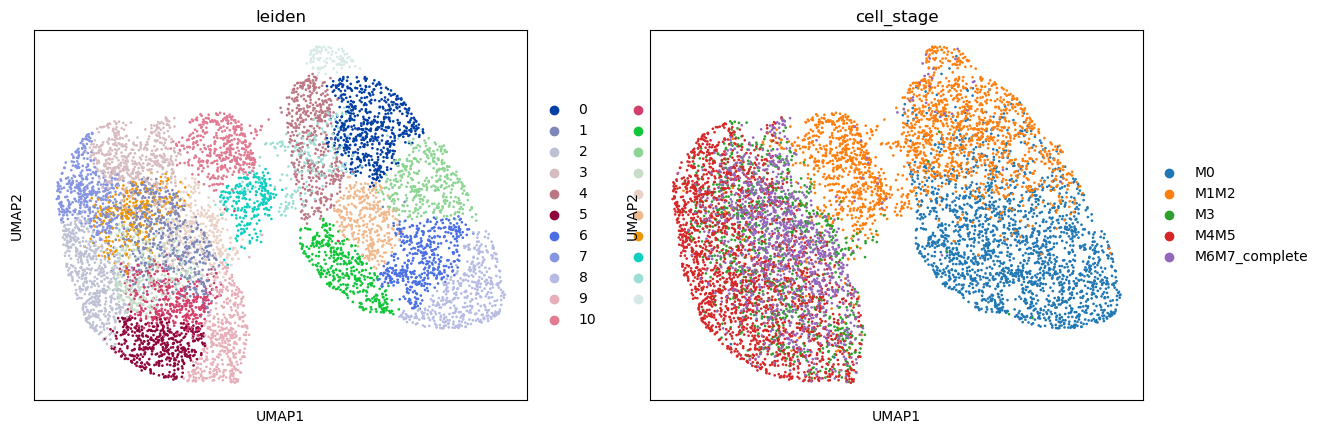

In [12]:
# Plot UMAP
sc.tl.leiden(obj)
sc.tl.umap(obj)
sc.pl.umap(obj, color=['leiden','cell_stage'])

In [13]:
obj.obs['nc_ratio'] = data['nuclear_volume'].values / data['cell_volume'].values
len(obj)

8179

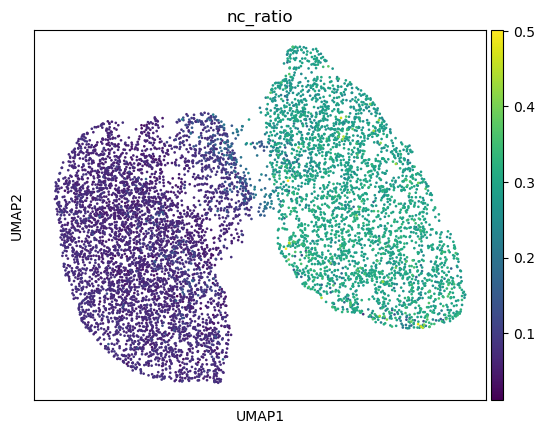

In [14]:
sc.pl.umap(obj, color='nc_ratio')

/opt/conda/lib/python3.10/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<AxesSubplot: xlabel='nc_ratio', ylabel='Count'>

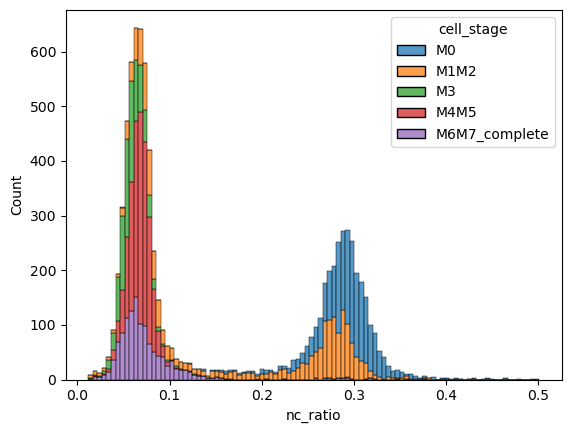

In [15]:
data['nc_ratio'] = data['nuclear_volume'] / data['cell_volume']
sns.histplot(data=data,x='nc_ratio',hue='cell_stage',bins=100,multiple='stack')

In [16]:
obj[(obj.obs['leiden'] == '4') &
   (obj.obs['cell_stage'] == 'M1M2')].obs

,cell_stage,CellId,leiden,nc_ratio
2003,M1M2,903040,4,0.291363
2010,M1M2,380635,4,0.301182
2024,M1M2,321391,4,0.259768
2027,M1M2,988762,4,0.247383
2051,M1M2,521897,4,0.341953
...,...,...,...,...
3957,M1M2,502113,4,0.280778
3974,M1M2,888439,4,0.270140
3978,M1M2,971061,4,0.275735
3980,M1M2,633850,4,0.269615


In [17]:
obj[obj.obs['leiden'] == '18'].obs

,cell_stage,CellId,leiden,nc_ratio
2018,M1M2,810430,18,0.070027
2023,M1M2,303432,18,0.102389
2035,M1M2,932551,18,0.078373
2042,M1M2,995983,18,0.075939
2056,M1M2,867300,18,0.230384
...,...,...,...,...
7365,M6M7_complete,531129,18,0.065923
7521,M6M7_complete,883365,18,0.064797
7657,M6M7_complete,809672,18,0.087890
7668,M6M7_complete,839687,18,0.094771


In [18]:
# Compute diffusion map
sc.tl.diffmap(obj)

# Define root cell
obj.uns['iroot'] = np.flatnonzero(obj.obs['leiden'] == '8')[0]

In [19]:
# Calculate diffusion pseudotime

sc.tl.dpt(obj, n_branchings=0, n_dcs=10)

In [20]:
obj

AnnData object with n_obs × n_vars = 8179 × 6
    obs: 'cell_stage', 'CellId', 'leiden', 'nc_ratio', 'dpt_pseudotime'
    var: 'mean', 'std'
    uns: 'neighbors', 'leiden', 'umap', 'leiden_colors', 'cell_stage_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_umap', 'X_diffmap'
    obsp: 'distances', 'connectivities'

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


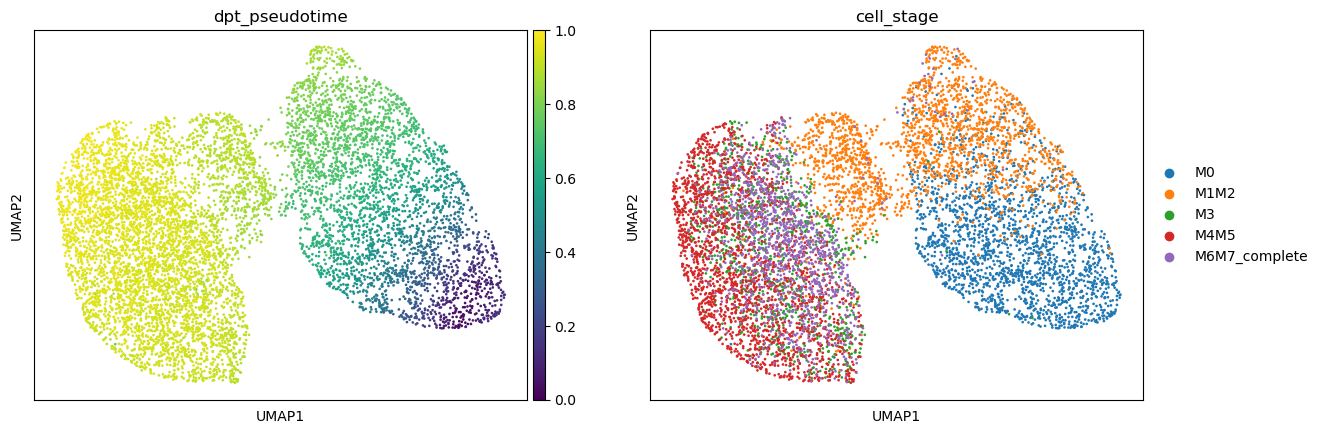

In [21]:
sc.pl.umap(obj, color=['dpt_pseudotime', 'cell_stage'])

In [22]:
obj.obs['log_dpt_pseudotime'] = np.log(1 - obj.obs['dpt_pseudotime'])

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


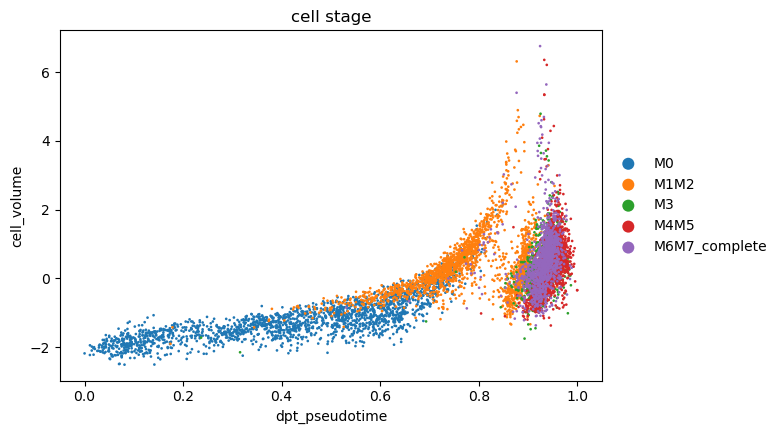

<Figure size 640x480 with 0 Axes>

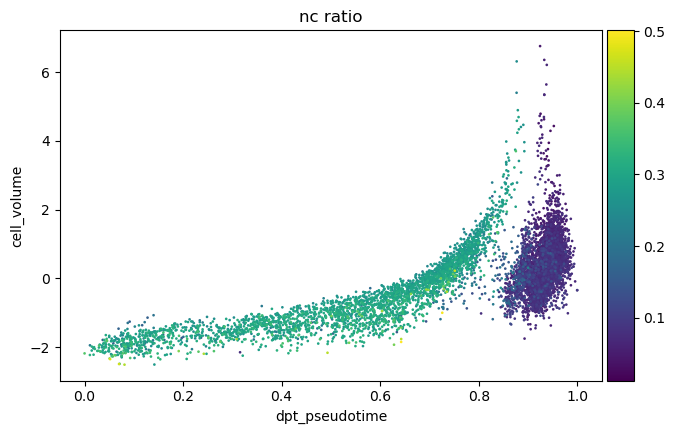

In [23]:
sc.pl.scatter(obj, x='dpt_pseudotime', y='cell_volume', color='cell_stage')
plt.figure()
sc.pl.scatter(obj, x='dpt_pseudotime', y='cell_volume', color='nc_ratio')

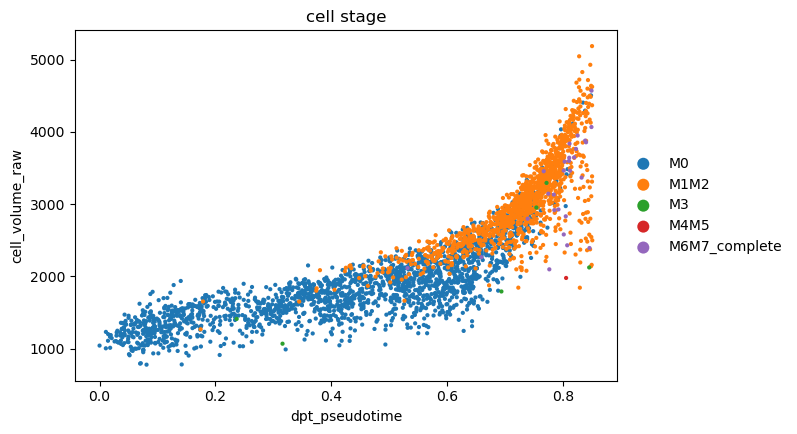

In [24]:
# Add volumes
obj.obs['cell_volume_raw'] = data_sub['cell_volume'].values

# Examine only dpt from 0 to 0.85
obj_early = obj[obj.obs['dpt_pseudotime'] < 0.85]

sc.pl.scatter(obj_early, x='dpt_pseudotime', y='cell_volume_raw', color='cell_stage')

In [25]:
# Fit exponential
def func(x, a, k, b):
    return a * np.exp(k * x) + b


xdata = obj_early.obs['dpt_pseudotime'].values
ydata = obj_early.obs['cell_volume_raw'].values
a0 = 1000
k0 = 1
b0 = 1000

popt, pcov = curve_fit(func, xdata, ydata, p0=[a0, k0, b0], bounds=(0, np.inf))

In [26]:
# Plot
a_fit = popt[0]
k_fit = popt[1]
b_fit = popt[2]

x_fit = np.linspace(0, 1, 30)


NameError: name 'which_bin' is not defined

In [28]:
from scipy import stats
bins = np.linspace(0,1,11)
which_bin = np.digitize(obj_early.obs['dpt_pseudotime'],bins)
binned = np.zeros(len(bins))
binned_std = np.zeros(len(bins))
for i,this_bin in enumerate(bins):
    binned[i] = np.mean(obj_early.obs['cell_volume_raw'].values[which_bin == i+1])
    binned_std[i] = np.std(obj_early.obs['cell_volume_raw'].values[which_bin == i+1])
    

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'cell volume (raw)')

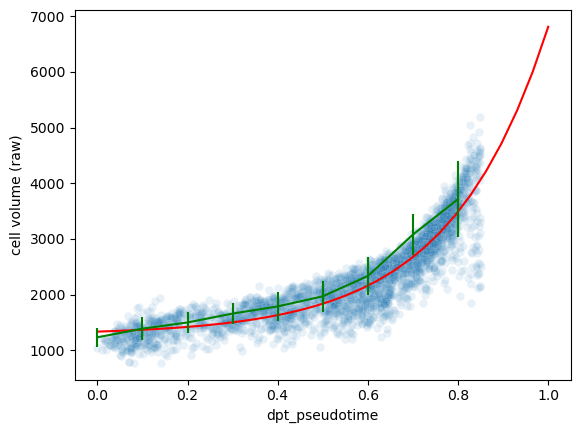

In [37]:

sns.scatterplot(data=obj_early.obs, x="dpt_pseudotime", y="cell_volume_raw",alpha=0.1)
plt.plot(x_fit,
         func(x_fit, a_fit, k_fit, b_fit),
         'r-')
plt.errorbar(bins,binned,yerr=binned_std,color='g')
plt.xlabel('dpt_pseudotime')
plt.ylabel('cell volume (raw)')

In [40]:
print(a_fit)
print(k_fit)
print(b_fit)

56.096829793887494
4.590589240309688
1280.6791942732132


In [ ]:
popt

In [ ]:
obj_early[:,'cell_volume'].X.squeeze().shape

In [ ]:
# Bin in pseudotime
bin_id, bins = pd.cut(obj.obs['dpt_pseudotime'], bins=10, retbins=True, labels=False)
obj.obs['dpt_pseudotime_bin'] = bin_id

In [ ]:
dpt_bins = pd.DataFrame()
dpt_bins['bin_freq'] = obj.obs['dpt_pseudotime_bin'].value_counts(normalize=True)
dpt_bins['bin_val'] = bins[1:]
dpt_bins['cumsum'] = 1 - dpt_bins.cumsum()['bin_freq']

In [ ]:
dpt_bins